<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/CERN_UE_KDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Fernando Ugalde Green 
f.ugaldegreen@estudiantec.cr

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

# Kernel Class

A collection of kernel functions from the state of the art, defined as:

* $gaussian(x,h)=exp(\frac{-x^2}{h^2})$
* $uniform(x,h)*=1$
* $parabolic(x,h)*=1-\frac{x^2}{h^2}$
* $exponential(x,h)=exp(\frac{-|x|}{h})$
* $linear(x,h)*=1-\frac{|x|}{h}$
* $cosine(x,h)*=cos(\frac{\pi x}{2h})$

\* functions are bound by $|x|<h$

In [ ]:
class Kernel:
  def gaussian(x, h):
    return np.exp(-x**2 / (2 * h**2))

  def uniform(x, h):
    y = np.zeros(x.shape)
    y[abs(x) < h] = 1
    return y

  def parabolic(x, h):
    domain = abs(x) < h
    y = np.zeros(x.shape)
    y[domain] = 1 - (x[domain] / h)**2
    return y

  def exponential(x, h):
    return np.exp(-abs(x) / h)

  def linear(x, h):
    domain = abs(x) < h
    y = np.zeros(x.shape)
    y[domain] = 1 - abs(x[domain]) / h
    return y

  def cosine(x, h):
    domain = abs(x) < h
    y = np.zeros(x.shape)
    y[domain] = np.cos(np.pi * x[domain] / (2 * h))
    return y

Plotting all the implemented kernels in the range $[-h, h]$ with $h=1$

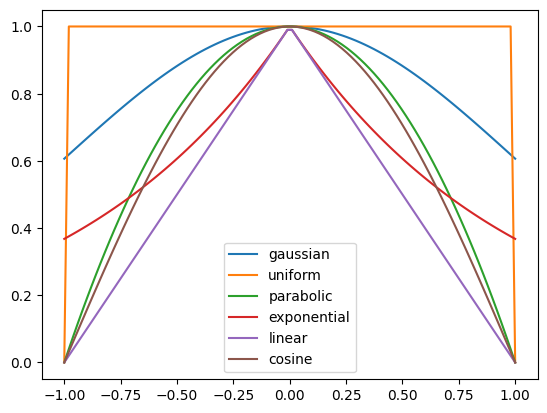

In [ ]:
def plot_kernels(h=1):
  kernels = Kernel.gaussian, Kernel.uniform, Kernel.parabolic, Kernel.exponential, Kernel.linear, Kernel.cosine
  x = np.linspace(-h, h, 100)

  for kernel in kernels:
    plt.plot(x, kernel(x, h), label=kernel.__name__)

  plt.legend()
  plt.show()

plot_kernels()

Rule-of-thumb formulas to approximate an optimal kernel bandwidth from data size $n$ and # of dimensions $d$.

* Scott: $n^{\frac{-1}{d+4}}$
* Silverman: $\frac{n(d+2)}{4}^\frac{-1}{d+4}$

In [ ]:
class BandwidthFactor:
  def scott(data):
    n, d = data.size, data.ndim
    return n**(-1 / (d + 4))

  def silverman(data):
    n, d = data.size, data.ndim
    return (n * (d + 2) / 4)**(-1 / (d + 4))

# Proper KDE implementation

* x: Data whose density we wish to estimate.
* y: Target space we wish to fit x into.
* h: Kernel bandwidth. If None, an optimal value is estimated through exhaustive grid search cross-validation.


In [ ]:
def kde(x, y, K=Kernel.gaussian, h=None, factor=BandwidthFactor.scott):
  if not h:
    '''
    h = factor(x)
    print('Computed bandwidth:', h)
    '''

    # Grid search cross-validation to optimize the bandwidth
    params = {'bandwidth': np.logspace(-1, 1, 100)}
    grid = GridSearchCV(KernelDensity(), params)
    grid.fit(x.reshape(-1, 1))
    h = grid.best_estimator_.bandwidth

    print('Best bandwidth:', h)

  sum = 0
  for i in range(x.size):
    sum += K(y - x[i], h)
  return sum

Simple test with normally distributed data:

* $(\mu_1, \sigma_1^2)=(0, 1)$
* $(\mu_2, \sigma_2^2)=(5, 1)$

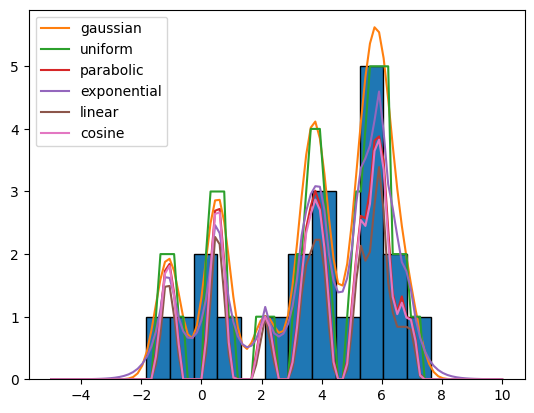

In [ ]:
def test_kernels(N, h=None):
  kernels = Kernel.gaussian, Kernel.uniform, Kernel.parabolic, Kernel.exponential, Kernel.linear, Kernel.cosine

  dist1 = np.random.normal(0, 1, int(.3 * N))
  dist2 = np.random.normal(5, 1, int(.7 * N))
  x = np.concatenate((dist1, dist2))

  x_plot = np.linspace(-5, 10, 100)
  bins = np.linspace(-5, 10, 20)

  plt.hist(x, bins, edgecolor='black')

  for kernel in kernels:
    plt.plot(x_plot, kde(x, x_plot, kernel, .4), label=kernel.__name__)

  plt.legend()
  plt.show()

test_kernels(20)

Test with feature space from toy example `MCD_ensemble_UQ.ipynb`

Min max: (0.049912047, 0.9455929)


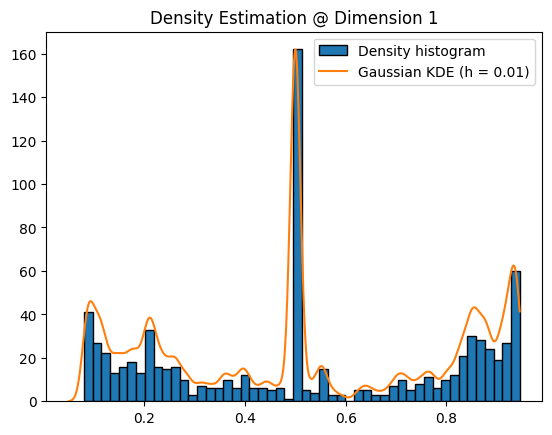

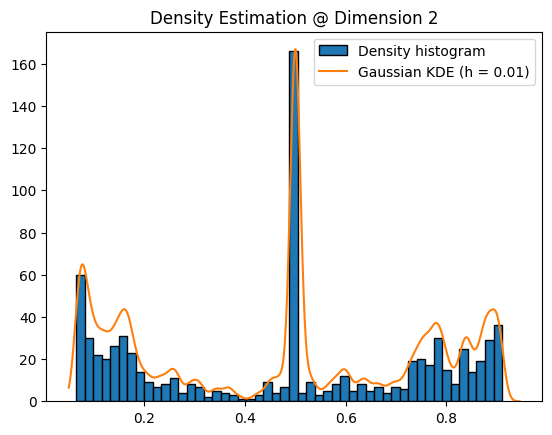

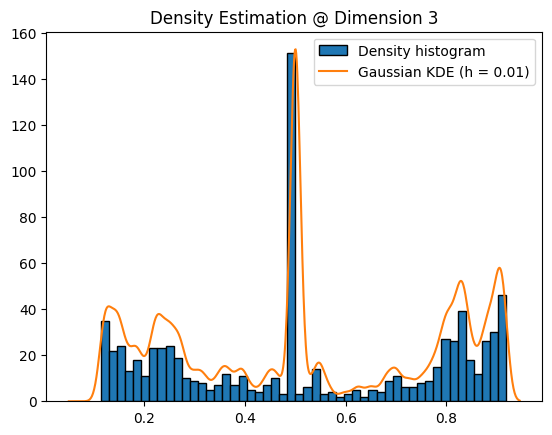

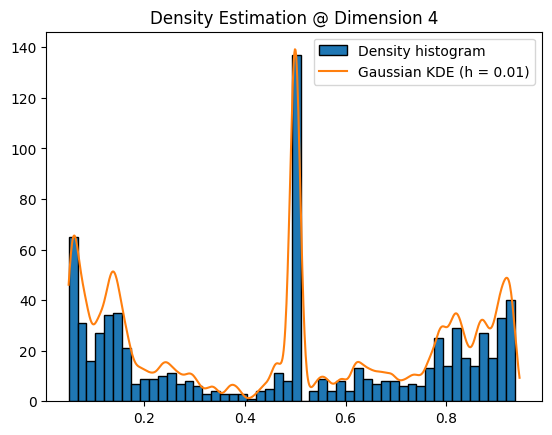

In [ ]:
def densities_kde():
  # X_feature_space_first_layer.npy imported from MCD_ensemble_UQ.ipynb

  dir = 'drive/MyDrive/Colab Notebooks/kde/'
  feature_space = np.load(dir + 'X_feature_space_first_layer.npy')

  x_plot_min_max = feature_space.min(), feature_space.max()
  print('Min max:', x_plot_min_max)
  x_plot = np.linspace(x_plot_min_max[0], x_plot_min_max[1], 800)

  for i in range(4):
    dim_data = feature_space[:, i]

    plt.hist(dim_data, 50, edgecolor='black', label='Density histogram')
    plt.plot(x_plot, kde(dim_data, x_plot, h=.01), label='Gaussian KDE (h = 0.01)')

    plt.title(f'Density Estimation @ Dimension {i + 1}')
    plt.legend()
    plt.show()

densities_kde()

# Legacy dim reduction code

Refer to *CERN UE - Dim Reduction* for latest code updates

In [ ]:
dir = 'drive/MyDrive/Colab Notebooks/kde/embeddings/layer4_pre_activation/'
pion_predictions = np.load(dir + 'pion_predictions.npy')
print('Embedding shape:', pion_predictions.shape)

Embedding shape: (948325, 128)


In [ ]:
pca = PCA(3)
pion_pca = pca.fit_transform(pion_predictions[:10000])
print('PCA shape:', pion_pca.shape)
print('Explained variance:', pca.explained_variance_)
print('Explained variance %:', pca.explained_variance_ratio_)
print('Score:', pca.score(pion_predictions[:10000]))

PCA shape: (10000, 3)
Explained variance: [8.722227 5.430489 4.446641]
Explained variance %: [0.32406145 0.2017618  0.16520838]
Score: -14.909519


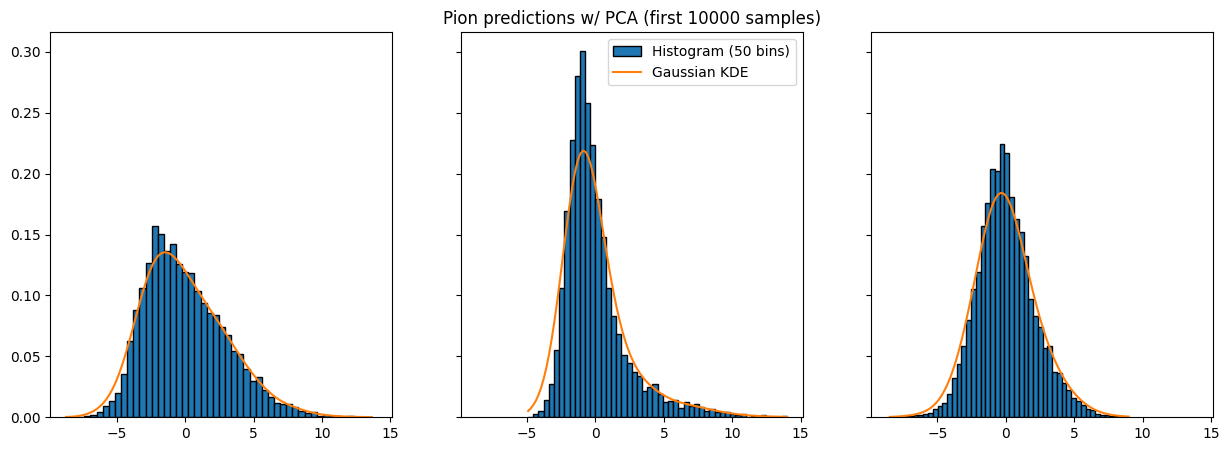

In [ ]:
bins = 50

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

for dim in range(pion_pca.shape[1]):
  data = pion_pca[:, dim]

  ax[dim].hist(data, bins, density=True, edgecolor='black', label=f'Histogram ({bins} bins)')

  hist_min, hist_max = data.min(), data.max()
  x_plot = np.linspace(hist_min, hist_max, 100)

  kde = KernelDensity().fit(data.reshape(-1, 1))
  pion_kde = np.exp(kde.score_samples(x_plot.reshape(-1, 1)))

  ax[dim].plot(x_plot, pion_kde, label='Gaussian KDE')

ax[1].set_title(f'Pion predictions w/ PCA (first {pion_pca.shape[0]} samples)')
ax[1].legend()

plt.show()

In [ ]:
tsne_parms = {
    'n_components': 3,
    'perplexity': 50,
    'n_iter': 300,
}

tsne = TSNE(**tsne_parms)
pion_tsne = tsne.fit_transform(pion_predictions[:10000])
print('TSNE shape:', pion_tsne.shape)
print('KL divergence:', tsne.kl_divergence_)

TSNE shape: (10000, 3)
KL divergence: 2.3471016883850098


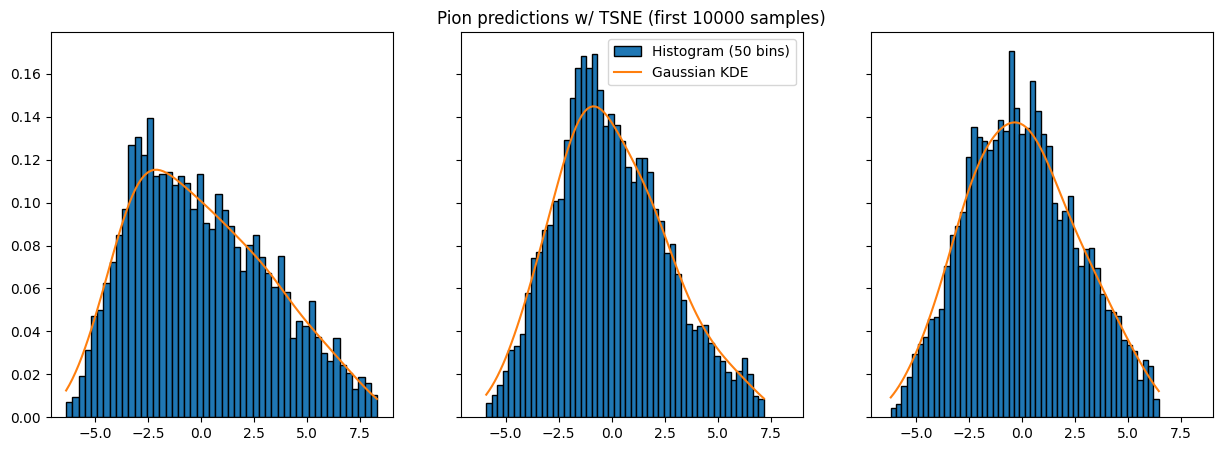

In [ ]:
bins = 50

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

for dim in range(pion_tsne.shape[1]):
  data = pion_tsne[:, dim]

  ax[dim].hist(data, bins, density=True, edgecolor='black', label=f'Histogram ({bins} bins)')

  hist_min, hist_max = data.min(), data.max()
  x_plot = np.linspace(hist_min, hist_max, 100)

  kde = KernelDensity().fit(data.reshape(-1, 1))
  pion_kde = np.exp(kde.score_samples(x_plot.reshape(-1, 1)))

  ax[dim].plot(x_plot, pion_kde, label='Gaussian KDE')

ax[1].set_title(f'Pion predictions w/ TSNE (first {pion_tsne.shape[0]} samples)')
ax[1].legend()

plt.show()